In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks, welch
from scipy.stats import entropy, skew, kurtosis
from scipy.fftpack import fft

# Create the folder if it doesn't exist
output_folder = "boxplots"
os.makedirs(output_folder, exist_ok=True)


def extract_wave_features(y_coordinates):
    """Extract wave-based features from y-coordinates."""
    if len(y_coordinates) < 2:
        return [np.nan] * 9

    # Normalize
    signal = (y_coordinates - np.min(y_coordinates)) / (np.max(y_coordinates) - np.min(y_coordinates) + 1e-6)
    signal_diff = np.diff(signal)

    # Peaks and troughs
    peaks, _ = find_peaks(signal)
    troughs, _ = find_peaks(-signal)

    # Zero crossings
    zero_crossings = np.where(np.diff(np.sign(signal - np.mean(signal))))[0]

    # Energy
    energy = np.sum(signal ** 2)

    # Entropy (histogram based)
    hist, _ = np.histogram(signal, bins=10, density=True)
    signal_entropy = entropy(hist + 1e-6)

    # Skewness & Kurtosis
    sk = skew(signal)
    kurt_val = kurtosis(signal)

    # FFT and Dominant Frequency
    spectrum = np.abs(fft(signal))
    dom_freq = np.argmax(spectrum[1:]) + 1

    return [
        len(peaks),
        len(troughs),
        len(zero_crossings),
        energy,
        signal_entropy,
        sk,
        kurt_val,
        dom_freq
    ]

def extract_features(image_path):
    """Extract standard and extra wave features from an image."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(image, 50, 150)
    y_coordinates = np.argwhere(edges > 0)[:, 0]

    if len(y_coordinates) < 2:
        return [np.nan] * 12

    # Core Features
    amplitude_diff = np.diff(y_coordinates)
    smoothness = np.var(amplitude_diff)
    avg_amplitude = np.mean(amplitude_diff)
    irregularities = len(np.where(np.abs(amplitude_diff) > avg_amplitude * 1.5)[0])

    # Extra Features
    extra = extract_wave_features(y_coordinates)

    return [smoothness, avg_amplitude, irregularities] + extra

def process_folder(folder_path, label):
    """Processes all images in a folder and extracts features."""
    data = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(folder_path, filename)
            features = extract_features(image_path)
            data.append({
                "Image": filename,
                "Label": label,
                "Smoothness": features[0],
                "Average Amplitude": features[1],
                "Irregularities": features[2],
                "Peak Count": features[3],
                "Trough Count": features[4],
                "Zero Crossings": features[5],
                "Wave Energy": features[6],
                "Signal Entropy": features[7],
                "Skewness": features[8],
                "Kurtosis": features[9],
                "Dominant Frequency": features[10]
            })
    return data

# === Set Folder Paths ===
healthy_folder = r'C:\Users\adklt\OneDrive - aegean.gr\Desktop\Paper\PhDOntologiesSpiral(Waves)\spiral\training\Healthy'
parkinsonian_folder = r'C:\Users\adklt\OneDrive - aegean.gr\Desktop\Paper\PhDOntologiesSpiral(Waves)\spiral\training\Parkinson'
#healthy_folder = r'C:\Users\adklt\OneDrive - aegean.gr\Desktop\Paper\PhDOntologiesSpiral(Waves)\spiral\testing\Healthy'
#parkinsonian_folder = r'C:\Users\adklt\OneDrive - aegean.gr\Desktop\Paper\PhDOntologiesSpiral(Waves)\spiral\testing\Parkinson'

# === Process Images ===
healthy_data = process_folder(healthy_folder, "Healthy")
parkinsonian_data = process_folder(parkinsonian_folder, "Parkinsonian")
all_data = healthy_data + parkinsonian_data
df = pd.DataFrame(all_data)

# === Save and Preview ===
df.to_csv("extracted_featuresnew.csv", index=False)
print("Saved to extracted_featurestesting.csv")
print(df.head())

# === Summary Stats ===
print("\n=== Summary Statistics by Label ===")
print(df.groupby("Label").mean(numeric_only=True))

# === Boxplots per Feature ===
features_to_plot = [col for col in df.columns if col not in ['Image', 'Label']]
for feature in features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Label', y=feature, data=df)
    plt.title(f"Boxplot of {feature}")
    plt.tight_layout()
    
    # Save the figure
    filename = f"{feature}_boxplot.png"
    filepath = os.path.join(output_folder, filename)
    plt.savefig(filepath)
    
    plt.close()  # Close the figure to free memory




Saved to extracted_featurestesting.csv
         Image    Label  Smoothness  Average Amplitude  Irregularities  \
0  V01HE02.png  Healthy    0.060325           0.064483             252   
1  V01HE03.png  Healthy    0.059635           0.063691             254   
2  V02HE02.png  Healthy    0.046262           0.048627             255   
3  V02HE03.png  Healthy    0.049514           0.052243             255   
4   V03HE2.png  Healthy    0.058065           0.061897             250   

   Peak Count  Trough Count  Zero Crossings  Wave Energy  Signal Entropy  \
0           0             0               1  1356.064584        2.298247   
1           0             0               1  1312.617635        2.289520   
2           0             0               1  1772.755880        2.292052   
3           0             0               1  1514.225455        2.289075   
4           0             0               1  1369.354709        2.290541   

   Skewness  Kurtosis  Dominant Frequency  
0 -0.087243 -1.

In [5]:
# === Descriptive Statistics for Each Feature by Label ===
print("\n=== Full Descriptive Statistics by Label ===")

# Get grouped descriptive stats
grouped_stats = df.groupby("Label")[features_to_plot].describe()

# Loop through features and print cleanly
for feature in features_to_plot:
    print(f"\n📊 === {feature} ===")
    display(grouped_stats[feature])  # works in Jupyter / shows nicely in console

    


=== Full Descriptive Statistics by Label ===

📊 === Smoothness ===


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Healthy,36.0,0.062919,0.007688,0.046262,0.058855,0.062668,0.070600,0.076755
Parkinsonian,36.0,0.055282,0.012967,0.019822,0.048931,0.058190,0.064787,0.074348



📊 === Average Amplitude ===


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Healthy,36.0,0.067545,0.008886,0.048627,0.062799,0.067181,0.076444,0.083773
Parkinsonian,36.0,0.058963,0.014497,0.020232,0.051594,0.062040,0.069637,0.080892



📊 === Irregularities ===


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Healthy,36.0,252.166667,2.158041,246.0,251.0,252.5,254.0,255.0
Parkinsonian,36.0,253.305556,1.260826,250.0,253.0,253.0,254.0,255.0



📊 === Peak Count ===


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Healthy,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Parkinsonian,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



📊 === Trough Count ===


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Healthy,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Parkinsonian,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



📊 === Zero Crossings ===


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Healthy,36.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
Parkinsonian,36.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0



📊 === Wave Energy ===


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Healthy,36.0,1243.502915,191.126487,926.114088,1094.219143,1218.157068,1359.387115,1772.755880
Parkinsonian,36.0,1556.374723,549.684459,917.765136,1205.028952,1391.824520,1655.620706,3519.630422



📊 === Signal Entropy ===


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Healthy,36.0,2.284628,0.010647,2.258401,2.278382,2.288095,2.292594,2.298247
Parkinsonian,36.0,2.280864,0.013417,2.249119,2.274468,2.285088,2.290668,2.299413



📊 === Skewness ===


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Healthy,36.0,0.036034,0.110047,-0.149115,-0.041846,0.030726,0.074558,0.363622
Parkinsonian,36.0,-0.014372,0.148047,-0.357621,-0.082312,-0.013946,0.059792,0.430393



📊 === Kurtosis ===


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Healthy,36.0,-1.113728,0.089433,-1.285895,-1.176516,-1.119337,-1.053703,-0.926294
Parkinsonian,36.0,-1.098703,0.117665,-1.300223,-1.186444,-1.122708,-1.025741,-0.835933



📊 === Dominant Frequency ===


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Healthy,36.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
Parkinsonian,36.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


C:\Users\adklt\anaconda3\Lib\site-packages\sdv\single_table\base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
C:\Users\adklt\anaconda3\Lib\site-packages\sdv\single_table\base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


🚀 Training CTGAN...
✅ Training complete.
📊 Sampling 200000 synthetic rows...
✅ Saved 1000 synthetic samples to → ctgan_synthetic_500_per_class.csv

🔍 Running classifier-based diagnostic evaluation...

📊 Classification Report (Trained on Real → Tested on Synthetic):
              precision    recall  f1-score   support

     Healthy       0.67      0.71      0.69       500
Parkinsonian       0.69      0.65      0.67       500

    accuracy                           0.68      1000
   macro avg       0.68      0.68      0.68      1000
weighted avg       0.68      0.68      0.68      1000



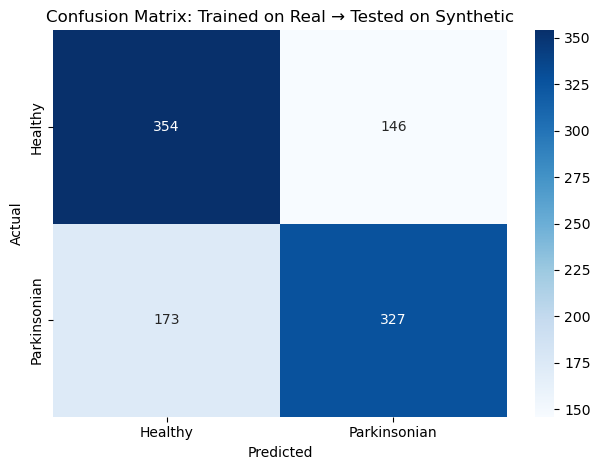


📥 Extracting True Positive synthetic samples...
✔ Found 681 True Positives
💾 Saved 354 True Positives for Healthy → ctgan_truepositives_healthy.csv
💾 Saved 327 True Positives for Parkinsonian → ctgan_truepositives_parkinsonian.csv


In [40]:
#Enough good 18/4/2025 my last use
import pandas as pd
from sdv.single_table import CTGANSynthesizer  # You can swap with TVAESynthesizer
from sdv.metadata import SingleTableMetadata
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------------------
# ⚙️ CONFIGURATION
# -----------------------------------------------------
USE_TVAE = False  # Set to True to try TVAE instead of CTGAN
SYNTH_PER_CLASS = 500
EPOCHS = 12000
SYNTH_TOTAL = 200000
SAVE_TP_FILES = True
RUN_EVALUATION = True

# -----------------------------------------------------
# 🧪 Load and preprocess real data
# -----------------------------------------------------
df_real = pd.read_csv("extracted_featuresnew.csv")
if "Image" in df_real.columns:
    df_real = df_real.drop(columns=["Image"])

df_real["Label"] = df_real["Label"].astype(str)

# -----------------------------------------------------
# 🧠 Metadata detection
# -----------------------------------------------------
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_real)

# -----------------------------------------------------
# 🚀 Train model
# -----------------------------------------------------
if USE_TVAE:
    from sdv.single_table import TVAESynthesizer
    model = TVAESynthesizer(metadata, epochs=EPOCHS)
    print("🚀 Training TVAE...")
else:
    model = CTGANSynthesizer(
        metadata,
        epochs=EPOCHS,
        batch_size=100,
        generator_lr=1e-4,
        discriminator_lr=1e-4
    )
    print("🚀 Training CTGAN...")

model.fit(df_real)
print("✅ Training complete.")

# -----------------------------------------------------
# 🎲 Sample synthetic data
# -----------------------------------------------------
print(f"📊 Sampling {SYNTH_TOTAL} synthetic rows...")
df_synth_all = model.sample(SYNTH_TOTAL)

# Filter to exactly N per class
synth_healthy = df_synth_all[df_synth_all["Label"] == "Healthy"].head(SYNTH_PER_CLASS)
synth_parkinsonian = df_synth_all[df_synth_all["Label"] == "Parkinsonian"].head(SYNTH_PER_CLASS)

df_synth = pd.concat([synth_healthy, synth_parkinsonian], ignore_index=True)

# Add synthetic image IDs
df_synth["Image"] = [
    f"Healthysynth{i+1}" if label == "Healthy" else f"Parkinsoniansynth{i+1}"
    for i, label in enumerate(df_synth["Label"])
]

output_file = "ctgan_synthetic_500_per_class.csv"
df_synth.to_csv(output_file, index=False)
print(f"✅ Saved {len(df_synth)} synthetic samples to → {output_file}")

# -----------------------------------------------------
# 🧠 Classifier Evaluation
# -----------------------------------------------------
if RUN_EVALUATION:
    print("\n🔍 Running classifier-based diagnostic evaluation...")

    X_real = df_real.drop(columns=["Label"])
    y_real = df_real["Label"]

    X_fake = df_synth.drop(columns=["Label", "Image"])
    y_fake = df_synth["Label"]

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_real, y_real)

    y_pred = clf.predict(X_fake)

    print("\n📊 Classification Report (Trained on Real → Tested on Synthetic):")
    print(classification_report(y_fake, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_fake, y_pred, labels=["Healthy", "Parkinsonian"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Healthy", "Parkinsonian"],
                yticklabels=["Healthy", "Parkinsonian"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix: Trained on Real → Tested on Synthetic")
    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------
    # ✅ Save only True Positive samples
    # -----------------------------------------------------
    print("\n📥 Extracting True Positive synthetic samples...")
    true_positive_mask = y_pred == y_fake.values
    df_true_positives = df_synth[true_positive_mask]
    print(f"✔ Found {len(df_true_positives)} True Positives")

    if SAVE_TP_FILES:
        # Save full TP set
        #df_true_positives.to_csv("ctgan_true_positives_all500v1.csv", index=False)
        #df_true_positives.to_csv("ctgan_true_positives_all500v1d.csv", index=False)
        # Save per-label TPs
        for label in ["Healthy", "Parkinsonian"]:
            df_tp_label = df_true_positives[df_true_positives["Label"] == label]
            out = f"ctgan_truepositives_{label.lower()}.csv"
            df_tp_label.to_csv(out, index=False)
            print(f"💾 Saved {len(df_tp_label)} True Positives for {label} → {out}")


In [42]:

import pandas as pd

# Load the two CSV files
df1 = pd.read_csv('ctgan_true_positives_all500v1.csv')
df2 = pd.read_csv('ctgan_true_positives_all500v1d.csv')

# Concatenate the dataframes
merged_df = pd.concat([df1, df2], ignore_index=True)

# Save the merged dataframe to a new CSV file
merged_df.to_csv('ctgan_true_positives_all1000.csv', index=False)

print("Files merged successfully into ctgan_true_positives_all1000.csv")


Files merged successfully into ctgan_true_positives_all1000.csv


C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1677423423.py:27: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


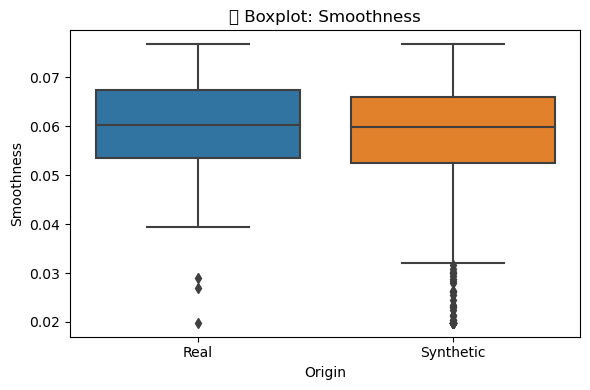

C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1677423423.py:27: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


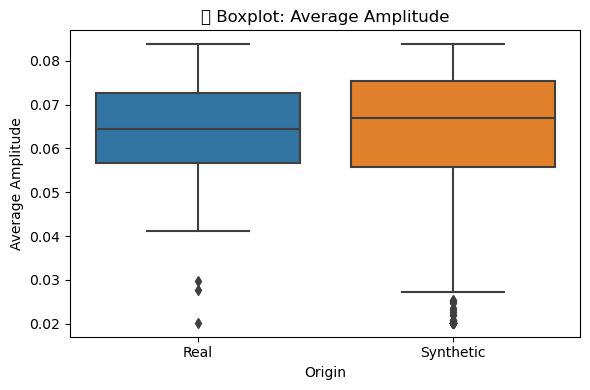

C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1677423423.py:27: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


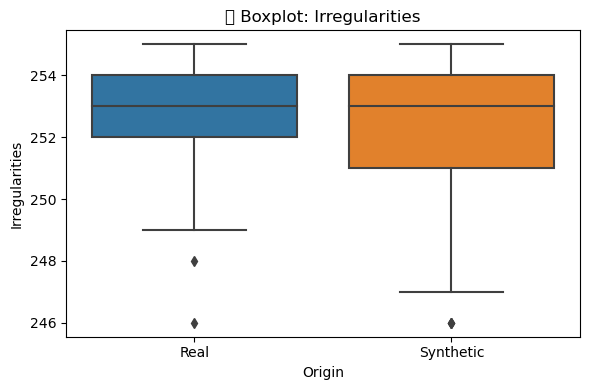

C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1677423423.py:27: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


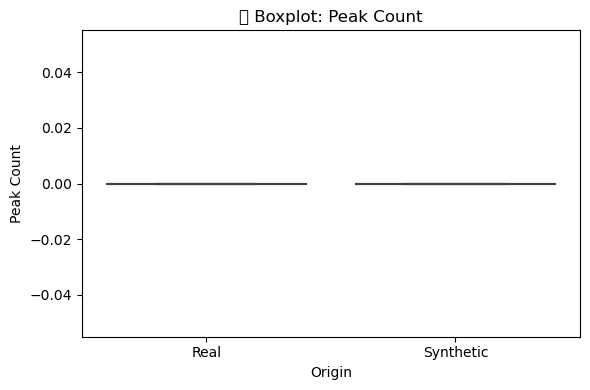

C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1677423423.py:27: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


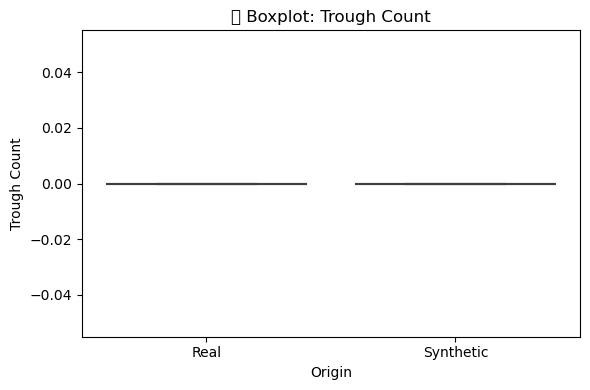

C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1677423423.py:27: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


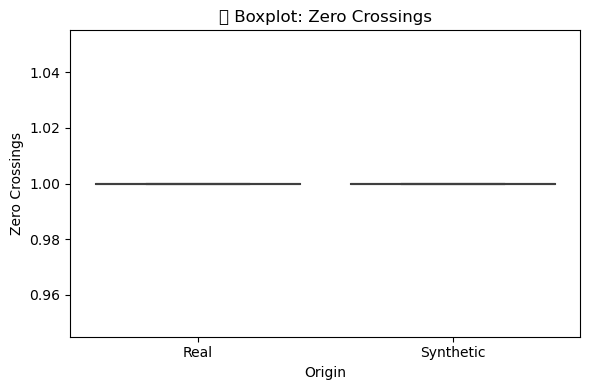

C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1677423423.py:27: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


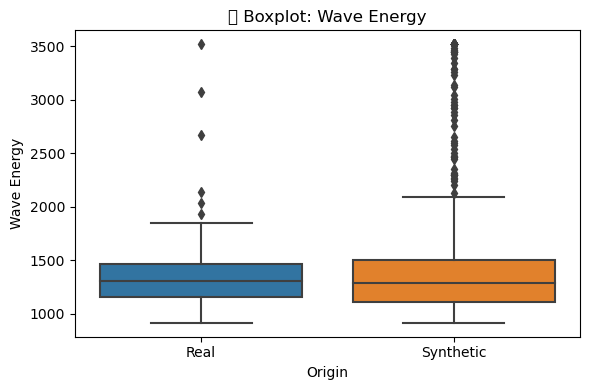

C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1677423423.py:27: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


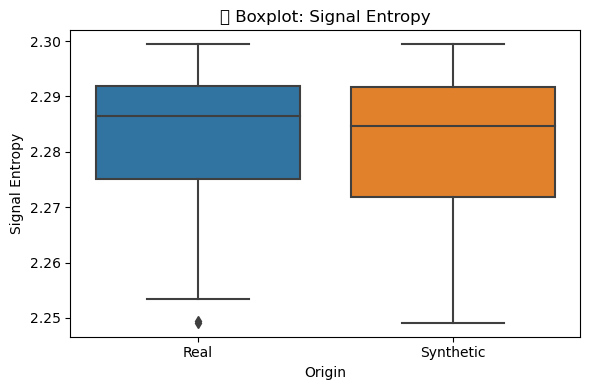

C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1677423423.py:27: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


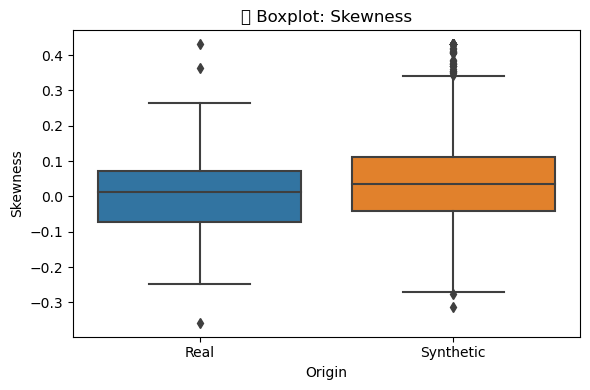

C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1677423423.py:27: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


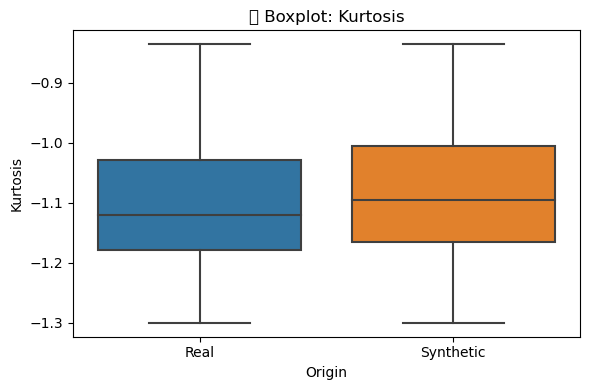

C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1677423423.py:27: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


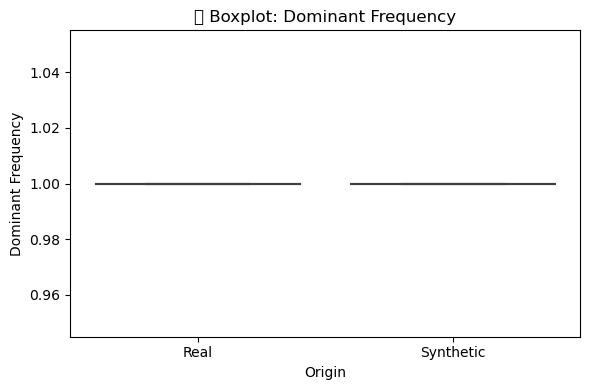

C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1677423423.py:37: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


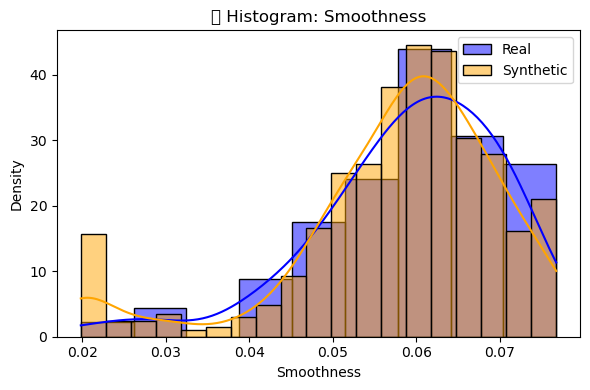

C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1677423423.py:37: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


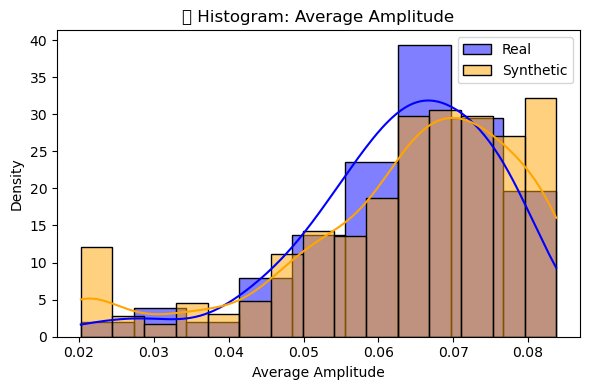

C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1677423423.py:37: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


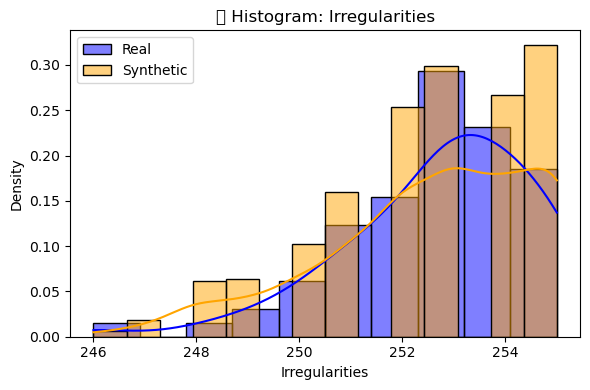

C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1677423423.py:37: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


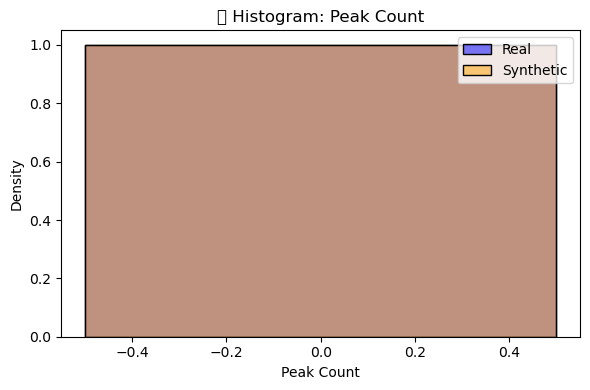

C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1677423423.py:37: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


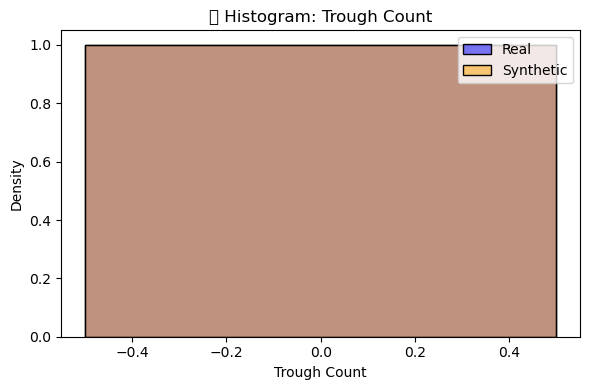

C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1677423423.py:37: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


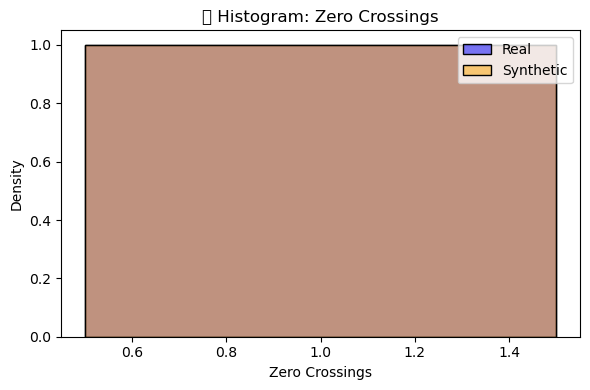

C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1677423423.py:37: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


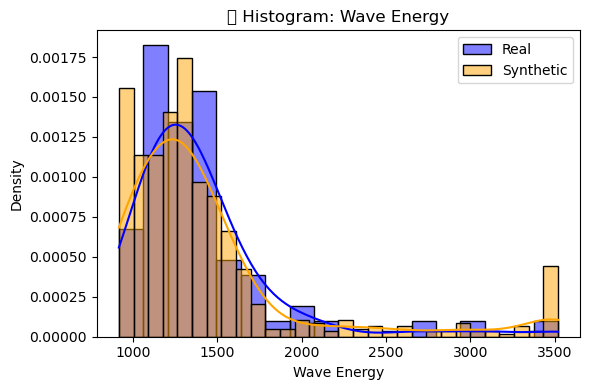

C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1677423423.py:37: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


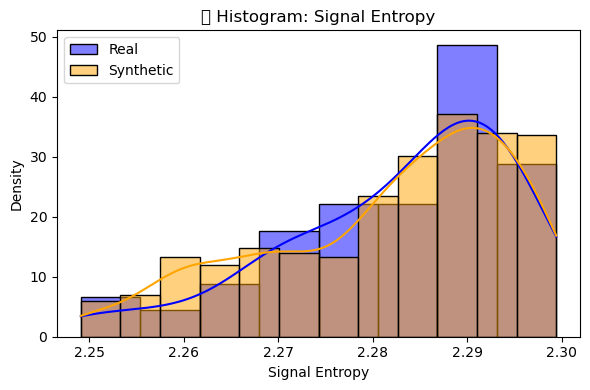

C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1677423423.py:37: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


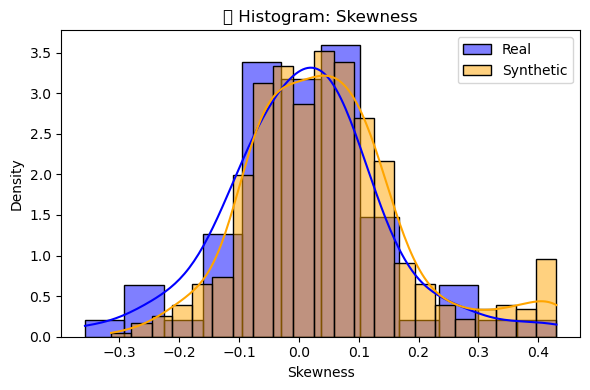

C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1677423423.py:37: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


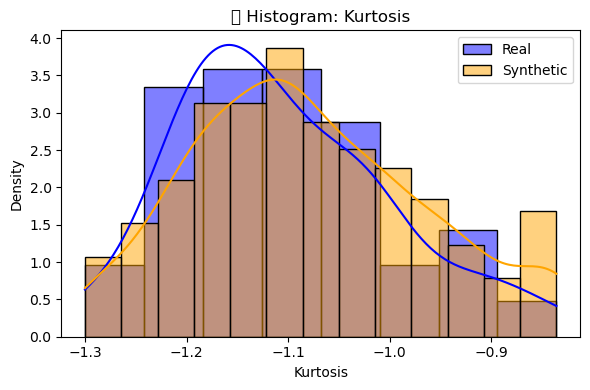

C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1677423423.py:37: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\adklt\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


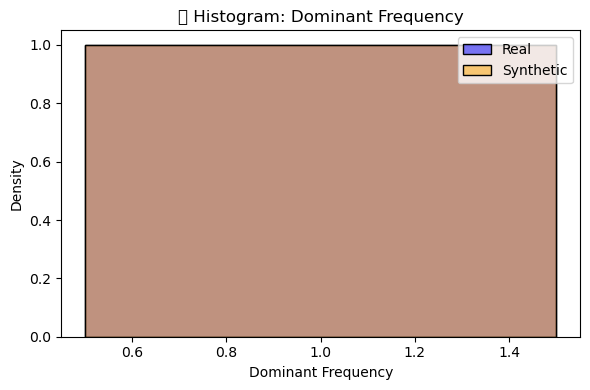

Smoothness               : p = 0.2898 → Same Distribution ✅
Average Amplitude        : p = 0.8346 → Same Distribution ✅
Irregularities           : p = 0.4362 → Same Distribution ✅
Peak Count               : Skipped (not enough variation)
Trough Count             : Skipped (not enough variation)
Zero Crossings           : Skipped (not enough variation)
Wave Energy              : p = 0.4351 → Same Distribution ✅
Signal Entropy           : p = 0.4562 → Same Distribution ✅
Skewness                 : p = 0.0299 → Different ⚠️
Kurtosis                 : p = 0.0569 → Same Distribution ✅
Dominant Frequency       : Skipped (not enough variation)


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd

# === Load real and synthetic ===
df_real = pd.read_csv("extracted_featuresnew.csv")



df_synth = pd.read_csv("ctgan_true_positives_all500v1d.csv")

# === Match columns ===
feature_cols = [col for col in df_real.columns if col not in ["Image", "Label"]]

# === Ensure Label is same format ===
df_real["Origin"] = "Real"
df_synth["Origin"] = "Synthetic"
df_combined = pd.concat([df_real, df_synth], ignore_index=True)

# === 1. Boxplots per feature ===
for col in feature_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="Origin", y=col, data=df_combined)
    plt.title(f"📦 Boxplot: {col}")
    plt.tight_layout()
    plt.show()

# === 2. Overlaid histograms ===
for col in feature_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_real[col], color="blue", label="Real", kde=True, stat="density")
    sns.histplot(df_synth[col], color="orange", label="Synthetic", kde=True, stat="density")
    plt.title(f"📈 Histogram: {col}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# === 3. T-test comparison per feature ===
for col in feature_cols:
    if df_real[col].nunique() < 2 or df_synth[col].nunique() < 2:
        print(f"{col:25}: Skipped (not enough variation)")
        continue

    try:
        t_stat, p_value = ttest_ind(df_real[col], df_synth[col], equal_var=False)
        result = "Same Distribution ✅" if p_value > 0.05 else "Different ⚠️"
        print(f"{col:25}: p = {p_value:.4f} → {result}")
    except Exception as e:
        print(f"{col:25}: Error — {e}")




📊 === Smoothness ===
              count      mean       std       min       25%       50%  \
Label                                                                   
Healthy       574.0  0.064466  0.007700  0.042001  0.059197  0.064289   
Parkinsonian  689.0  0.049066  0.015814  0.019822  0.043434  0.052439   

                   75%       max  
Label                             
Healthy       0.070838  0.076755  
Parkinsonian  0.060193  0.076755  

📊 === Average Amplitude ===
              count      mean       std       min       25%       50%  \
Label                                                                   
Healthy       574.0  0.069887  0.009006  0.031630  0.063893  0.069920   
Parkinsonian  689.0  0.052156  0.017553  0.020232  0.041606  0.055911   

                   75%       max  
Label                             
Healthy       0.076802  0.083773  
Parkinsonian  0.065271  0.083773  

📊 === Irregularities ===
              count        mean       std    min    25%  

In [3]:
!pip install shap


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       183
           1       0.89      0.95      0.92       200

    accuracy                           0.91       383
   macro avg       0.92      0.91      0.91       383
weighted avg       0.92      0.91      0.91       383

🧩 Confusion Matrix:
[[159  24]
 [  9 191]]


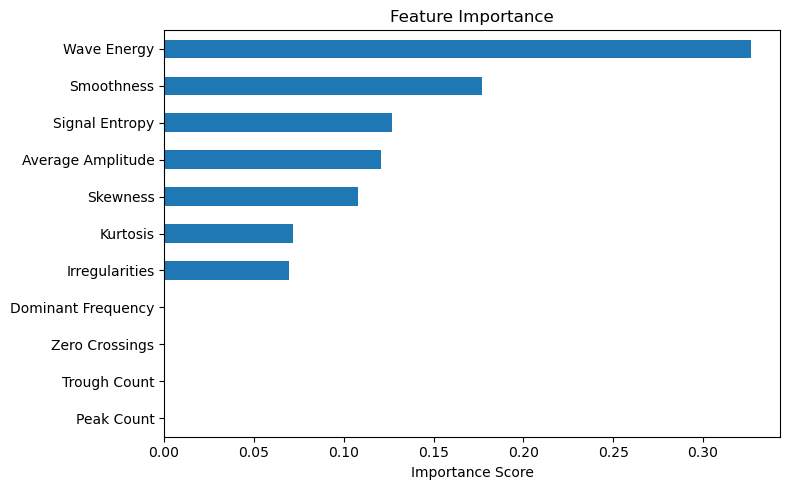


📈 SHAP Summary Plots:


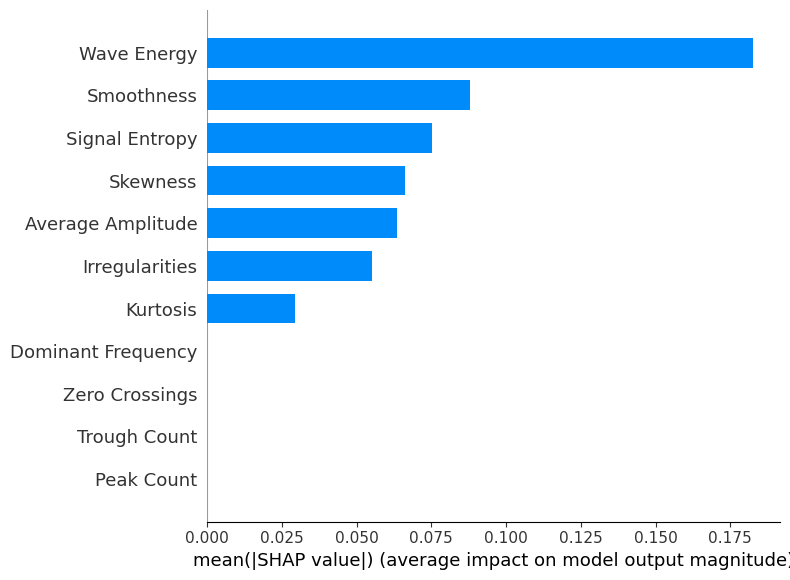

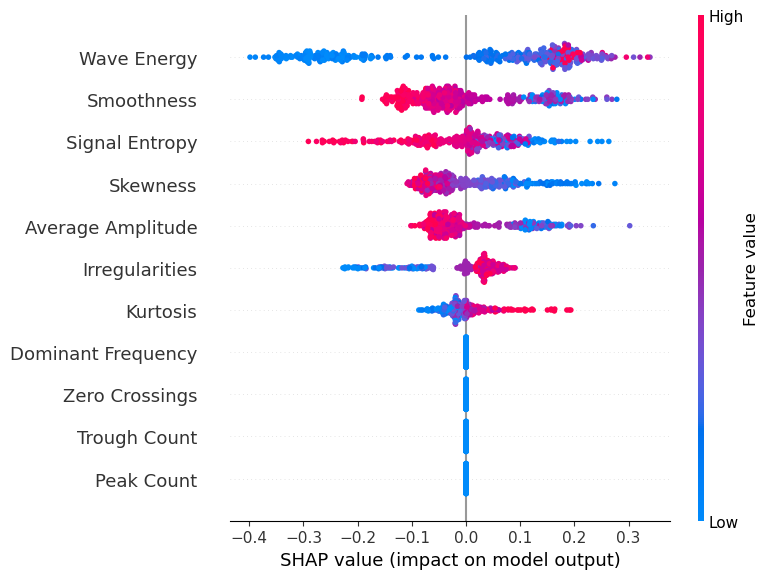


📊 Shapiro-Wilk Normality Test:
Smoothness          : p = 0.0000 → Not Normal
Kurtosis            : p = 0.0000 → Not Normal
Signal Entropy      : p = 0.0000 → Not Normal
Wave Energy         : p = 0.0000 → Not Normal
Irregularities      : p = 0.0000 → Not Normal
Skewness            : p = 0.0000 → Not Normal

🔗 Correlation with Label (0=Healthy, 1=Parkinsonian):
Smoothness          : Spearman r = -0.535, p = 0.0000
Kurtosis            : Spearman r = 0.045, p = 0.1107
Signal Entropy      : Spearman r = -0.285, p = 0.0000
Wave Energy         : Spearman r = 0.685, p = 0.0000
Irregularities      : Spearman r = 0.303, p = 0.0000
Skewness            : Spearman r = -0.344, p = 0.0000


In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, pearsonr, spearmanr
import shap
import warnings


# === 1. Load data ===
#df = pd.read_csv("ctgan_true_positives_all1000.csv")


# Load the two CSV files
df1 = pd.read_csv('ctgan_true_positives_all1000.csv')
#df2 = pd.read_csv('ctgan_true_positives_all500v2.csv')




# === 2. Target variable (convert to 0/1) ===
df["target"] = df["Label"].map({"Healthy": 0, "Parkinsonian": 1})

# === 3. Define features (drop non-numeric or ID columns) ===
X = df.drop(columns=["Label", "Image", "target"])
y = df["target"]

# === 4. Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# === 5. Train model ===
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# === 6. Evaluate ===
y_pred = model.predict(X_test)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("🧩 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# === 7. Feature importance (optional) ===
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind="barh", figsize=(8, 5), title="Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


green_features = ["Smoothness", "Kurtosis", "Signal Entropy", "Wave Energy", "Irregularities", "Skewness"]

# === 8. SHAP Explanation ===
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Handle 3D output for binary classifier
if isinstance(shap_values, list):
    shap_arr = shap_values[1]  # use SHAP values for class 1 (Parkinsonian)
else:
    shap_arr = shap_values

# If 3D, reduce to 2D using the second class (axis 2 index 1)
if shap_arr.ndim == 3:
    shap_arr = shap_arr[:, :, 1]

# Plot only if shape matches
if shap_arr.shape == X_test.shape:
    print("\n📈 SHAP Summary Plots:")
    shap.summary_plot(shap_arr, X_test, plot_type="bar")
    shap.summary_plot(shap_arr, X_test)
else:
    print(f"❌ SHAP shape mismatch. SHAP: {shap_arr.shape}, X_test: {X_test.shape}")



# === Normality Tests (Shapiro-Wilk) ===
print("\n📊 Shapiro-Wilk Normality Test:")
normality = {}
for col in green_features:
    stat, p = shapiro(df[col])
    normality[col] = "Normal" if p > 0.05 else "Not Normal"
    print(f"{col:<20}: p = {p:.4f} → {normality[col]}")

# === Correlation Tests ===
print("\n🔗 Correlation with Label (0=Healthy, 1=Parkinsonian):")
for col in green_features:
    if normality[col] == "Normal":
        corr, pval = pearsonr(df[col], y)
        test = "Pearson"
    else:
        corr, pval = spearmanr(df[col], y)
        test = "Spearman"
    print(f"{col:<20}: {test:<8} r = {corr:.3f}, p = {pval:.4f}")



In [46]:
import joblib
from sklearn.metrics import accuracy_score

# === 8. Save the trained model ===
joblib.dump(model, "random_forest_ctgan_model.pkl")
print("💾 Model saved as random_forest_ctgan_model.pkl")

# ---------------------------------------------------
# 🧪 Apply model to extracted real data
# ---------------------------------------------------

# === Load real data ===
df_real = pd.read_csv("extracted_featuresnew.csv")

# Convert label to 0/1 target
df_real["target"] = df_real["Label"].map({"Healthy": 0, "Parkinsonian": 1})

# Drop non-feature columns
X_real = df_real.drop(columns=["Label", "Image", "target"], errors="ignore")
y_real = df_real["target"]

# === Load model and predict ===
model = joblib.load("random_forest_ctgan_model.pkl")
y_real_pred = model.predict(X_real)

# === Evaluate on real data ===
print("\n🔍 Evaluation on Real Data:")
print(classification_report(y_real, y_real_pred))
print("🧩 Confusion Matrix (Real Data):")
print(confusion_matrix(y_real, y_real_pred))
print(f"✅ Accuracy: {accuracy_score(y_real, y_real_pred):.4f}")


💾 Model saved as random_forest_ctgan_model.pkl

🔍 Evaluation on Real Data:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        36
           1       0.75      0.75      0.75        36

    accuracy                           0.75        72
   macro avg       0.75      0.75      0.75        72
weighted avg       0.75      0.75      0.75        72

🧩 Confusion Matrix (Real Data):
[[27  9]
 [ 9 27]]
✅ Accuracy: 0.7500


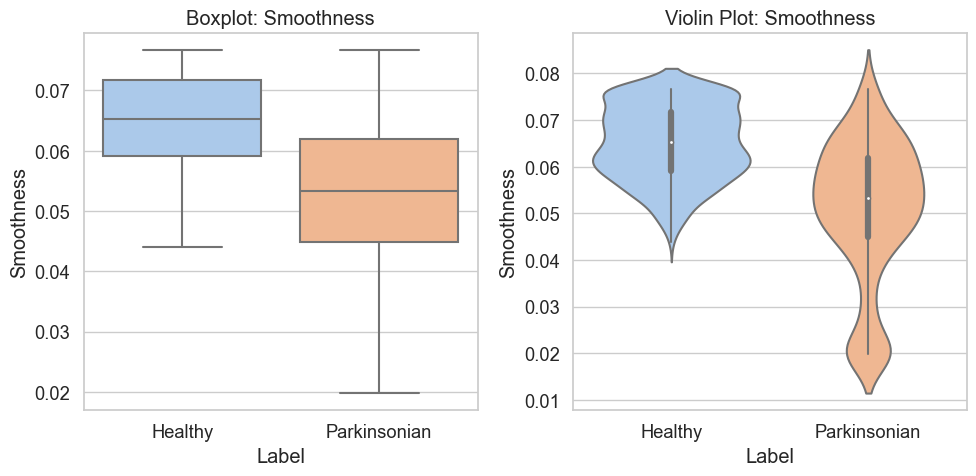

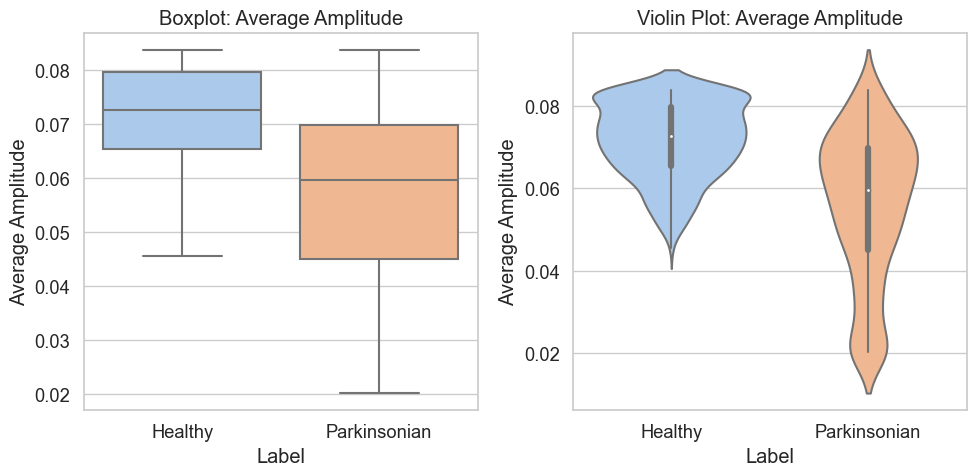

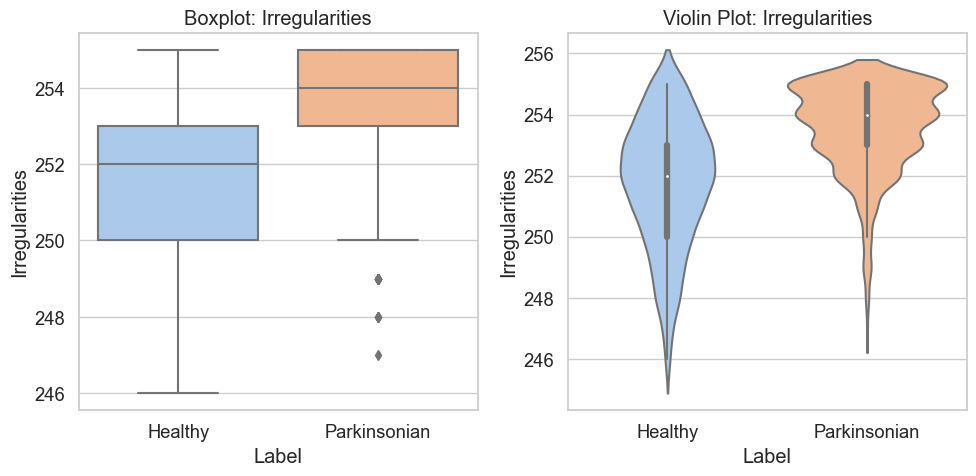

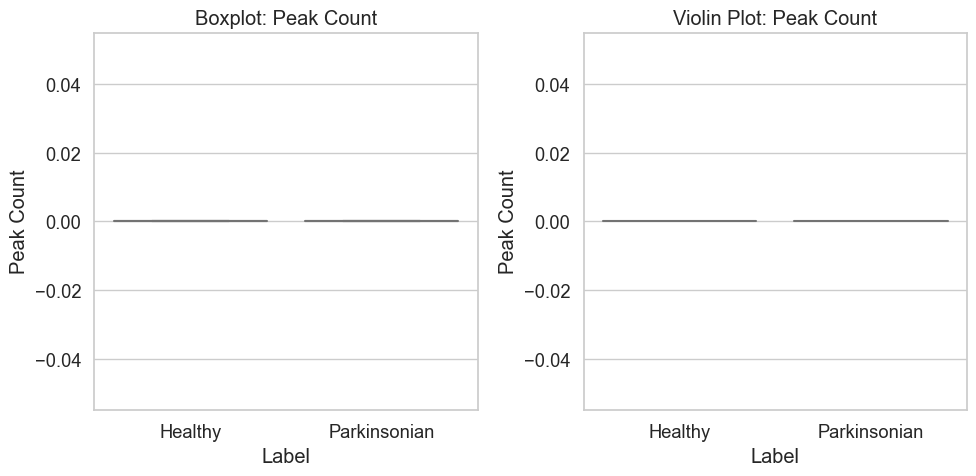

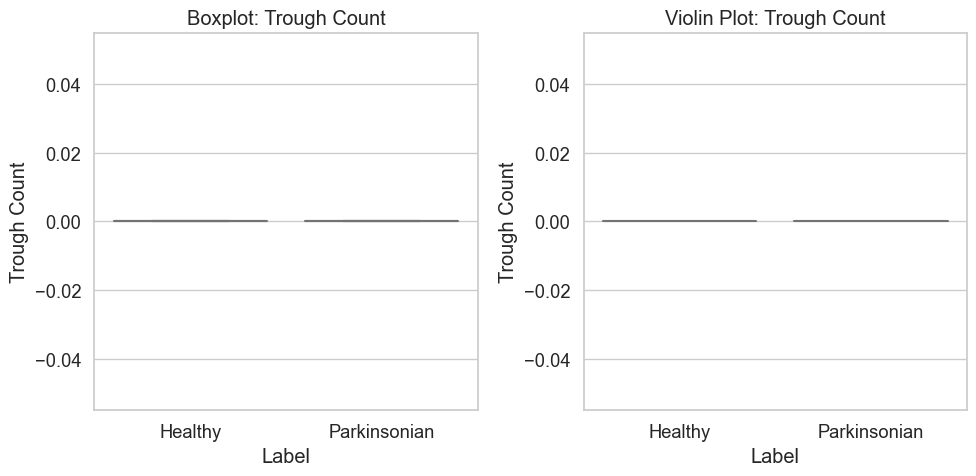

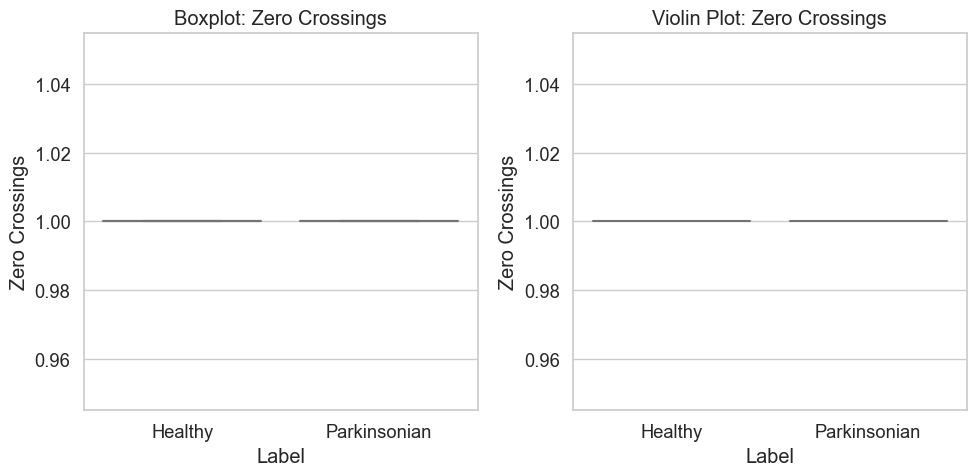

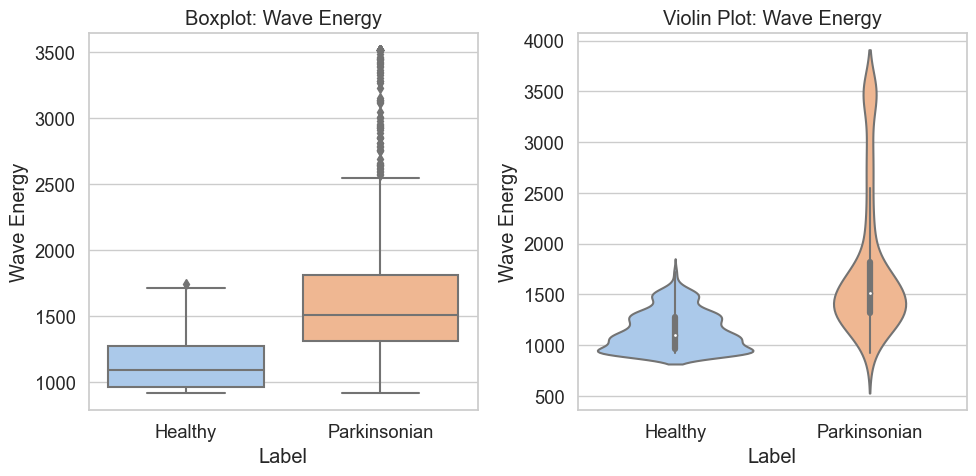

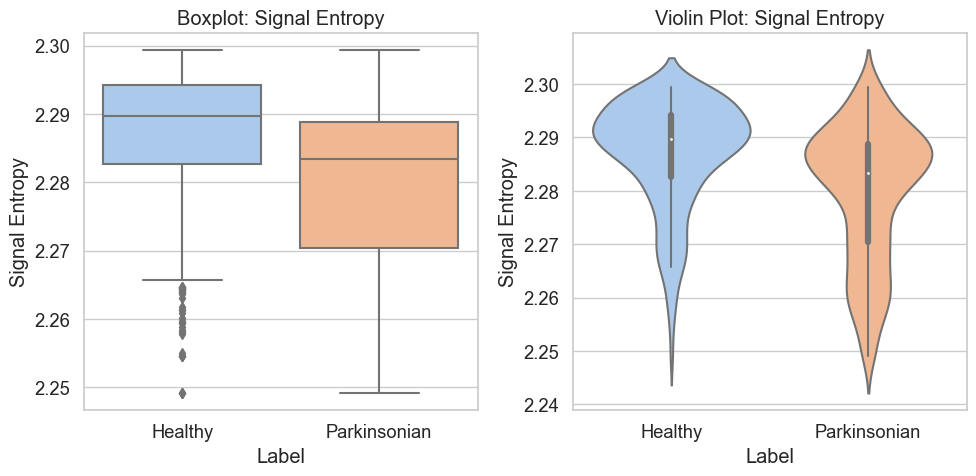

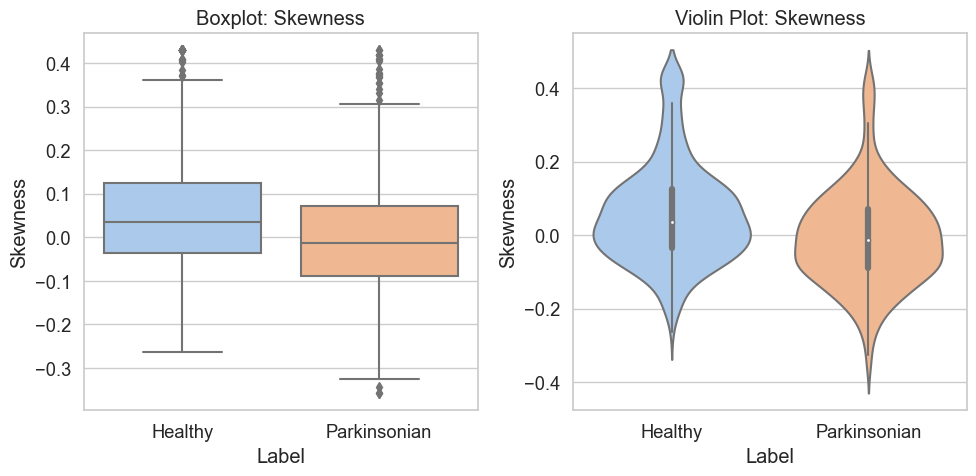

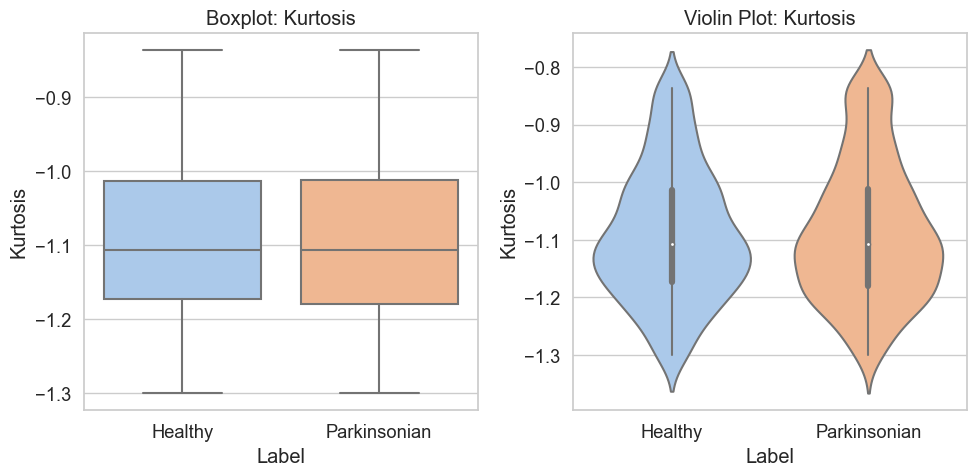

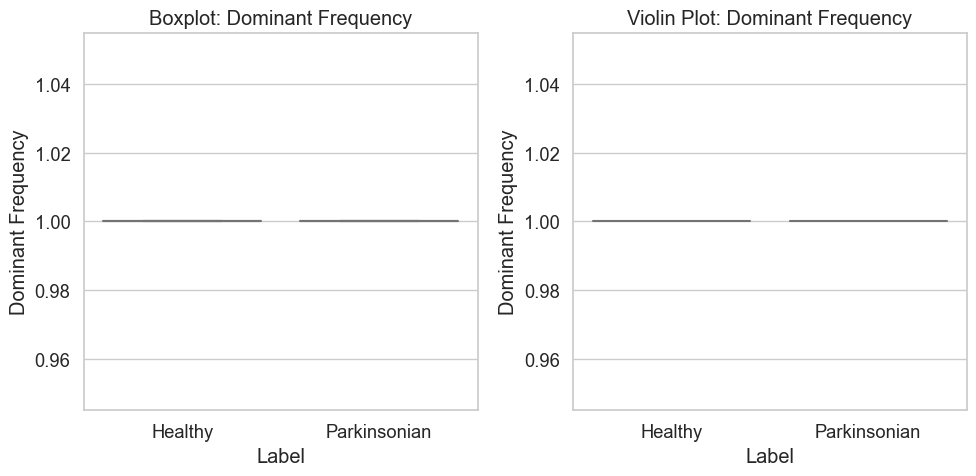

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create folders if they don't exist
os.makedirs("figures", exist_ok=True)
os.makedirs("fuzzysets", exist_ok=True)

# Load data
df_synth = pd.read_csv("ctgan_true_positives_all1000.csv")
feature_columns = [col for col in df_synth.columns if col not in ['Image', 'Label']]

sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

for feature in feature_columns:
    plt.figure(figsize=(10, 5))
    
    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x='Label', y=feature, data=df_synth)
    plt.title(f"Boxplot: {feature}")
    
    # Violin plot
    plt.subplot(1, 2, 2)
    sns.violinplot(x='Label', y=feature, data=df_synth, inner="box")
    plt.title(f"Violin Plot: {feature}")
    
    plt.tight_layout()
    plt.savefig(f"figures/{feature}_distribution.png")
    plt.show()


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# === 1. Load Data ===
df = pd.read_csv("ctgan_true_positives_all1000.csv")
os.makedirs("plots/miniplots", exist_ok=True)
os.makedirs("plots/projections", exist_ok=True)

# === 2. Get feature columns ===
feature_cols = [col for col in df.columns if col not in ['Image', 'Label']]

# === 3. Generate 10 diverse plots ===
for feature in feature_cols[:10]:  # adjust slice for more features
    plt.figure(figsize=(14, 8))
    
    # Histogram
    plt.subplot(2, 3, 1)
    sns.histplot(df[feature], kde=True)
    plt.title(f"{feature} - Histogram")

    # Boxplot
    plt.subplot(2, 3, 2)
    sns.boxplot(x='Label', y=feature, data=df)
    plt.title(f"{feature} - Boxplot")

    # Violin plot
    plt.subplot(2, 3, 3)
    sns.violinplot(x='Label', y=feature, data=df)
    plt.title(f"{feature} - Violin Plot")

    # Strip plot
    plt.subplot(2, 3, 4)
    sns.stripplot(x='Label', y=feature, data=df, jitter=True, alpha=0.5)
    plt.title(f"{feature} - Strip Plot")

    # KDE
    plt.subplot(2, 3, 5)
    sns.kdeplot(data=df, x=feature, hue='Label', fill=True)
    plt.title(f"{feature} - KDE by Label")

    # ECDF
    plt.subplot(2, 3, 6)
    for label in df['Label'].unique():
        subset = df[df['Label'] == label]
        sns.ecdfplot(subset[feature], label=label)
    plt.title(f"{feature} - ECDF")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"plots/miniplots/{feature}_summary.png")
    plt.close()

# === 4. PCA 2D and 3D ===
from sklearn.preprocessing import StandardScaler
X = df[feature_cols]
y = df["Label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 2D
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)
pca_df_2d = pd.DataFrame(X_pca_2d, columns=['PC1', 'PC2'])
pca_df_2d['Label'] = y

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_2d, x='PC1', y='PC2', hue='Label')
plt.title("PCA - 2D Projection")
plt.savefig("plots/projections/pca_2d.png")
plt.close()

# PCA 3D
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
for label in pca_df_2d['Label'].unique():
    idx = pca_df_2d['Label'] == label
    ax.scatter(X_pca_3d[idx, 0], X_pca_3d[idx, 1], X_pca_3d[idx, 2], label=label)
ax.set_title("PCA - 3D Projection")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.savefig("plots/projections/pca_3d.png")
plt.close()

# === 5. t-SNE Visualization ===
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
tsne_df['Label'] = y

plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='Label')
plt.title("t-SNE - 2D Projection")
plt.savefig("plots/projections/tsne_2d.png")
plt.close()

# === 6. Correlation Heatmap ===
plt.figure(figsize=(12, 10))
corr = df[feature_cols].corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Features")
plt.savefig("plots/projections/correlation_heatmap.png")
plt.close()

# === 7. Pairplot (use subset for clarity) ===
sns.pairplot(df[feature_cols[:5] + ['Label']], hue='Label')
plt.savefig("plots/projections/pairplot.png")
plt.close()

print("✅ All visualizations have been saved to the 'plots/' directory.")


C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1983381527.py:43: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=feature, hue='Label', fill=True)
C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1983381527.py:43: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=feature, hue='Label', fill=True)
C:\Users\adklt\AppData\Local\Temp\ipykernel_12848\1983381527.py:43: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=feature, hue='Label', fill=True)
C:\Users\adklt\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


✅ All visualizations have been saved to the 'plots/' directory.


✅ Accuracy: 92.89%

📊 Confusion Matrix:
[[106   9]
 [  9 129]]

📋 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.92      0.92      0.92       115
Parkinsonian       0.93      0.93      0.93       138

    accuracy                           0.93       253
   macro avg       0.93      0.93      0.93       253
weighted avg       0.93      0.93      0.93       253



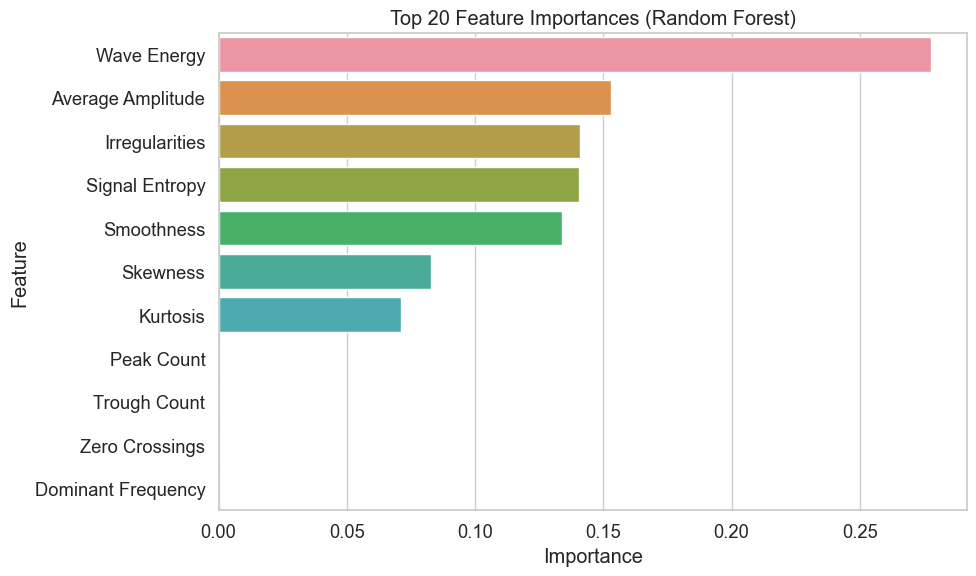


📉 Cross-validation accuracy (5-fold): 0.91 ± 0.02


C:\Users\adklt\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\adklt\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


✅ Saved predictions to predictions/real_data_with_rf_predictions.csv


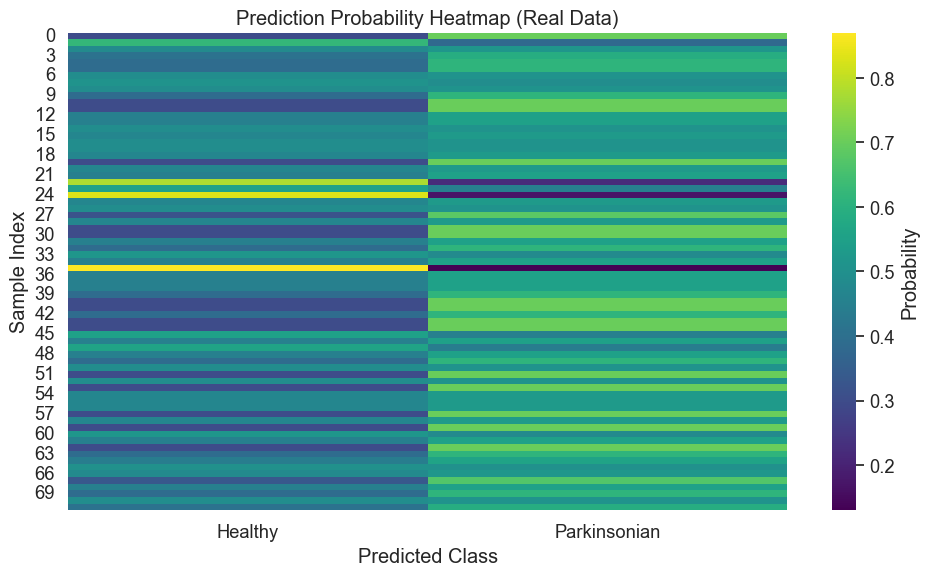

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import os

# === 1. Load real dataset ===
real_df = pd.read_csv("extracted_featuresnew.csv")
real_features = real_df.drop(columns=["Image", "Label"], errors='ignore')

# === 2. Scale real data with the same method ===
scaler = StandardScaler()
real_scaled = scaler.fit_transform(real_features)

# === 3. Train model again on synthetic data for prediction ===
# (Normally you'd save/load the trained model, but here we retrain for simplicity)

# Load synthetic data
synth_df = pd.read_csv("ctgan_true_positives_all1000.csv")
X_synth = synth_df.drop(columns=["Image", "Label"], errors='ignore')
y_synth = synth_df["Label"]
if y_synth.dtype == object:
    y_synth = y_synth.map({"Healthy": 0, "Parkinsonian": 1})

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_synth, y_synth)

# === 4. Predict on real data ===
y_pred_real = rf.predict(real_scaled)
proba_real = rf.predict_proba(real_scaled)

# === 5. Attach predictions back to dataframe ===
real_df["Predicted_Label"] = y_pred_real
real_df["Predicted_Label"] = real_df["Predicted_Label"].map({0: "Healthy", 1: "Parkinsonian"})

# === 6. Save output ===
os.makedirs("predictions", exist_ok=True)
real_df.to_csv("predictions/real_data_with_rf_predictions.csv", index=False)
print("✅ Saved predictions to predictions/real_data_with_rf_predictions.csv")

# === 7. Heatmap of prediction probabilities ===
plt.figure(figsize=(10, 6))
sns.heatmap(proba_real, cmap="viridis", xticklabels=["Healthy", "Parkinsonian"], cbar_kws={'label': 'Probability'})
plt.title("Prediction Probability Heatmap (Real Data)")
plt.xlabel("Predicted Class")
plt.ylabel("Sample Index")
plt.tight_layout()
plt.savefig("predictions/real_prediction_heatmap.png")
plt.show()


In [50]:
import pandas as pd
import numpy as np

# === 1. Load real dataset ===
df = pd.read_csv("ctgan_true_positives_all1000.csv")  # Adjust path if needed

# === 2. Selected features for fuzzy sets ===
features_to_fuzzify = [
    "Wave Energy", "Irregularities", "Signal Entropy", 
    "Skewness", "Kurtosis", "Smoothness", "Irregularities", "Average Amplitude"
]

# === 3. Function to compute triangular fuzzy sets ===
def tight_fuzzy_sets(data, feature):
    values = data[feature].dropna()
    min_val = values.min()
    max_val = values.max()
    
    # Key percentiles (tight overlap)
    p20 = np.percentile(values, 20)
    p35 = np.percentile(values, 35)
    p40 = np.percentile(values, 40)
    p50 = np.percentile(values, 50)
    p60 = np.percentile(values, 60)
    p65 = np.percentile(values, 65)
    p80 = np.percentile(values, 80)
    
    return [
        {"Feature": feature, "Set": "Low",    "A": min_val, "B": p20, "C": p40},
        {"Feature": feature, "Set": "Medium", "A": p35,     "B": p50, "C": p65},
        {"Feature": feature, "Set": "High",   "A": p60,     "B": p80, "C": max_val}
    ]

# === 4. Generate fuzzy sets for all selected features ===
fuzzy_definitions = []
for feat in features_to_fuzzify:
    fuzzy_definitions.extend(tight_fuzzy_sets(df, feat))

# === 5. Save & display results ===
fuzzy_df = pd.DataFrame(fuzzy_definitions)
print("📊 Tight Fuzzy Sets with Minimal Overlap:")
print(fuzzy_df)

# Optional: save to CSV
fuzzy_df.to_csv("tight_fuzzy_sets.csv", index=False)
print("\n✅ Saved to: tight_fuzzy_sets.csv")



📊 Tight Fuzzy Sets with Minimal Overlap:
              Feature     Set            A            B            C
0         Wave Energy     Low   917.765136  1034.343286  1211.038055
1         Wave Energy  Medium  1169.017630  1287.489969  1416.875960
2         Wave Energy    High  1359.815092  1592.945928  3519.630422
3      Irregularities     Low   246.000000   251.000000   252.000000
4      Irregularities  Medium   252.000000   253.000000   254.000000
5      Irregularities    High   253.000000   254.000000   255.000000
6      Signal Entropy     Low     2.249119     2.272657     2.284137
7      Signal Entropy  Medium     2.282455     2.286809     2.289927
8      Signal Entropy    High     2.288833     2.293290     2.299413
9            Skewness     Low    -0.357621    -0.080322    -0.017587
10           Skewness  Medium    -0.031371     0.014581     0.065292
11           Skewness    High     0.045163     0.120252     0.430393
12           Kurtosis     Low    -1.300223    -1.191184    -1.

In [51]:
import pandas as pd

# === 1. Load your dataset ===
df = pd.read_csv("extracted_featuresnew.csv")  # Update this path if needed

# === 2. Define tight fuzzy sets (minimal overlap) ===
fuzzy_sets = {
    "Wave Energy": [
        ("Low", 917.765136, 1034.343286, 1211.038055),
        ("Medium", 1169.017630, 1287.489969, 1416.875960),
        ("High", 1359.815092, 1592.945928, 3519.630422)
    ],
    "Irregularities": [
        ("Low", 246.000000, 251.000000, 252.000000),
        ("Medium", 252.000000, 253.000000, 254.000000),
        ("High", 253.000000, 254.000000, 255.000000)
    ],
    "Signal Entropy": [
        ("Low", 2.249119, 2.272657, 2.284137),
        ("Medium", 2.282455, 2.286809, 2.289927),
        ("High", 2.288833, 2.293290, 2.299413)
    ],
    "Skewness": [
        ("Low", -0.357621, -0.080322, -0.017587),
        ("Medium", -0.031371, 0.014581, 0.065292),
        ("High", 0.045163, 0.120252, 0.430393)
    ],
    "Kurtosis": [
        ("Low", -1.300223, -1.191184, -1.131120),
        ("Medium", -1.146514, -1.106764, -1.054824),
        ("High", -1.075387, -0.988812, -0.835933)
    ],
    "Smoothness": [
        ("Low", 0.019822, 0.049614, 0.057431),
        ("Medium", 0.056119, 0.060259, 0.064683),
        ("High", 0.063055, 0.069708, 0.076755)
    ],
    "Average Amplitude": [
        ("Low", 0.020232, 0.053158, 0.064042),
        ("Medium", 0.062134, 0.067730, 0.072455),
        ("High", 0.071007, 0.077622, 0.083773)
    ]
}

# === 3. Triangular membership function ===
def get_membership_level(value, sets):
    best_label = None
    best_membership = -1
    for label, a, b, c in sets:
        if value <= a or value >= c:
            membership = 0
        elif a < value <= b:
            membership = (value - a) / (b - a)
        elif b < value < c:
            membership = (c - value) / (c - b)
        else:
            membership = 0
        if membership > best_membership:
            best_membership = membership
            best_label = label
    return best_label

# === 4. Apply fuzzy logic per feature ===
output_df = df[["Image"]].copy()
for feature in fuzzy_sets:
    output_df[feature + " Level"] = df[feature].apply(lambda val: get_membership_level(val, fuzzy_sets[feature]))

# === 5. Export result ===
output_df.to_csv("individuals_with_updated_fuzzy_levels.csv", index=False)
print("✅ Saved: individuals_with_updated_fuzzy_levels.csv")


✅ Saved: individuals_with_updated_fuzzy_levels.csv


In [52]:
# === 6. Plot fuzzy membership level distributions ===
fuzzy_plot_folder = "fuzzy_membership_plots"
os.makedirs(fuzzy_plot_folder, exist_ok=True)


# For each fuzzy-analyzed feature, plot membership distribution
for feature in fuzzy_sets:
    level_col = feature + " Level"
    plt.figure(figsize=(6, 4))
    sns.countplot(x=level_col, data=output_df, order=["Low", "Medium", "High"])
    plt.title(f"Fuzzy Membership Levels for {feature}")
    plt.xlabel("Membership Level")
    plt.ylabel("Count")
    plt.tight_layout()
    
    # Save the plot
    plot_path = os.path.join(fuzzy_plot_folder, f"{feature}_fuzzy_levels.png")
    plt.savefig(plot_path)
    plt.close()


In [53]:
# === 6. Plot triangular membership functions ===
triangular_plot_folder = "triangular_membership_plots"
os.makedirs(triangular_plot_folder, exist_ok=True)

import matplotlib.pyplot as plt
import numpy as np

for feature, sets in fuzzy_sets.items():
    plt.figure(figsize=(6, 4))

    # Plot each fuzzy set for the current feature
    for label, a, b, c in sets:
        x = np.linspace(a, c, 500)
        y = np.piecewise(
            x,
            [x <= a, (x > a) & (x <= b), (x > b) & (x < c), x >= c],
            [0,
             lambda x: (x - a) / (b - a) if b != a else 1,
             lambda x: (c - x) / (c - b) if c != b else 1,
             0]
        )
        plt.plot(x, y, label=label)

    plt.title(f"Triangular Membership Functions for {feature}")
    plt.xlabel(feature)
    plt.ylabel("Membership Degree")
    plt.ylim(-0.05, 1.05)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save the plot
    plot_path = os.path.join(triangular_plot_folder, f"{feature}_triangular.png")
    plt.savefig(plot_path)
    plt.close()


In [55]:
import pandas as pd

# === 1. Load the full fuzzy-level dataset ===
df = pd.read_csv("individuals_with_updated_fuzzy_levels.csv")  # Update path if needed

# === 2. Infer true label from filename ===
def infer_true_label(filename):
    if 'H' in filename:
        return "Healthy"
    elif 'P' in filename:
        return "Parkinsonian"
    else:
        return "Unknown"

df["True Label"] = df["Image"].apply(infer_true_label)

# === 3. Filter only known ground truth ===
df = df[df["True Label"].isin(["Healthy", "Parkinsonian"])]

# === 4. Count unique fuzzy-level patterns per group ===
features = ["Smoothness Level", "Wave Energy Level", "Signal Entropy Level"]

# Get most frequent patterns for Healthy
healthy_df = df[df["True Label"] == "Healthy"]
healthy_patterns = healthy_df[features].value_counts().reset_index(name="Count")
healthy_patterns["Group"] = "Healthy"

# Get most frequent patterns for Parkinsonian
parkinsonian_df = df[df["True Label"] == "Parkinsonian"]
parkinsonian_patterns = parkinsonian_df[features].value_counts().reset_index(name="Count")
parkinsonian_patterns["Group"] = "Parkinsonian"

# Combine and show
rule_candidates = pd.concat([healthy_patterns, parkinsonian_patterns], ignore_index=True)
rule_candidates = rule_candidates.sort_values(by=["Group", "Count"], ascending=[True, False])

# === 5. Save the candidate rule patterns ===
rule_candidates.to_csv("candidate_fuzzy_rules_full_dataset.csv", index=False)
print("✅ Saved: candidate_fuzzy_rules_full_dataset.csv")

✅ Saved: candidate_fuzzy_rules_full_dataset.csv
